Julian Andrés y Pablo Domínguez

# **DISEÑO DE LA CARTERA**

In [59]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import missingno as msno

Hemos elegido estos activos por su demanda inelástica en caso de que Estados Unidos entre en recesión:


*   **Supermercados:** Costco, Walmart y Kroger: siempre habrá demanda para bienes de primera necesidad, es una demanda inelástica

*   **Sanidad:** Eli Lilly and Company (farmacéutica), AbbVie (farmacéutica), United Health Group (aseguradora): En una recesión, consideramos que la sociedad no dejaría de consumir fármacos, y la idea de abandonar la suscripción de una aseguradora en Estados Unidos donde los costes hospitalarios son mucho mayores que en la mayoría de países es muy poco probable.

*   **Armamento y seguridad**: Lockheed Martin: consideramos que por razones políticas y tensiones geopolíticas crecientes, su demanda crecería. Además, gran parte (70%) de sus ingresos viene del Departamento de Defensa estadounidense, comprando aviones F-35, helicópteros o misiles. Además, se espera un incremento del 12% en el gasto en defensa.

*   **Tabaco**: Al ser una sustancia adictiva, es poco probable que su precio caiga.






In [60]:
tickers = ["WMT", "COST", "KR", "LMT", "LLY", "ABBV", "UNH", "MO"]

In [61]:
precios = yf.download(tickers, start = "2019-1-1", end = "2023-12-31", multi_level_index= False, auto_adjust = False)['Adj Close']
precios

[*********************100%***********************]  8 of 8 completed


Ticker,ABBV,COST,KR,LLY,LMT,MO,UNH,WMT
Date,,,,,,,,
2019-01-02,66.900146,186.144623,23.834394,105.114410,224.121170,30.135334,221.528564,28.215210
2019-01-03,64.695892,182.199219,23.878046,101.847885,218.491196,29.970325,215.487427,28.070116
2019-01-04,66.780182,187.490082,24.148695,104.913124,224.383591,30.740351,218.007599,28.245438
2019-01-07,67.754852,188.180984,24.375689,105.480408,226.957260,29.811420,218.426163,28.577957
2019-01-08,68.069763,189.590057,24.847136,106.450294,228.472656,29.982542,221.346619,28.777462
...,...,...,...,...,...,...,...,...
2023-12-22,146.723526,652.133667,43.890930,565.716431,433.584534,36.509884,510.109161,51.456898
2023-12-26,146.420486,655.066284,43.968712,565.994080,435.480499,36.491791,509.834717,51.378056
2023-12-27,146.666718,662.196716,43.958988,576.745239,434.310059,36.347057,512.540527,51.860928


<Axes: >

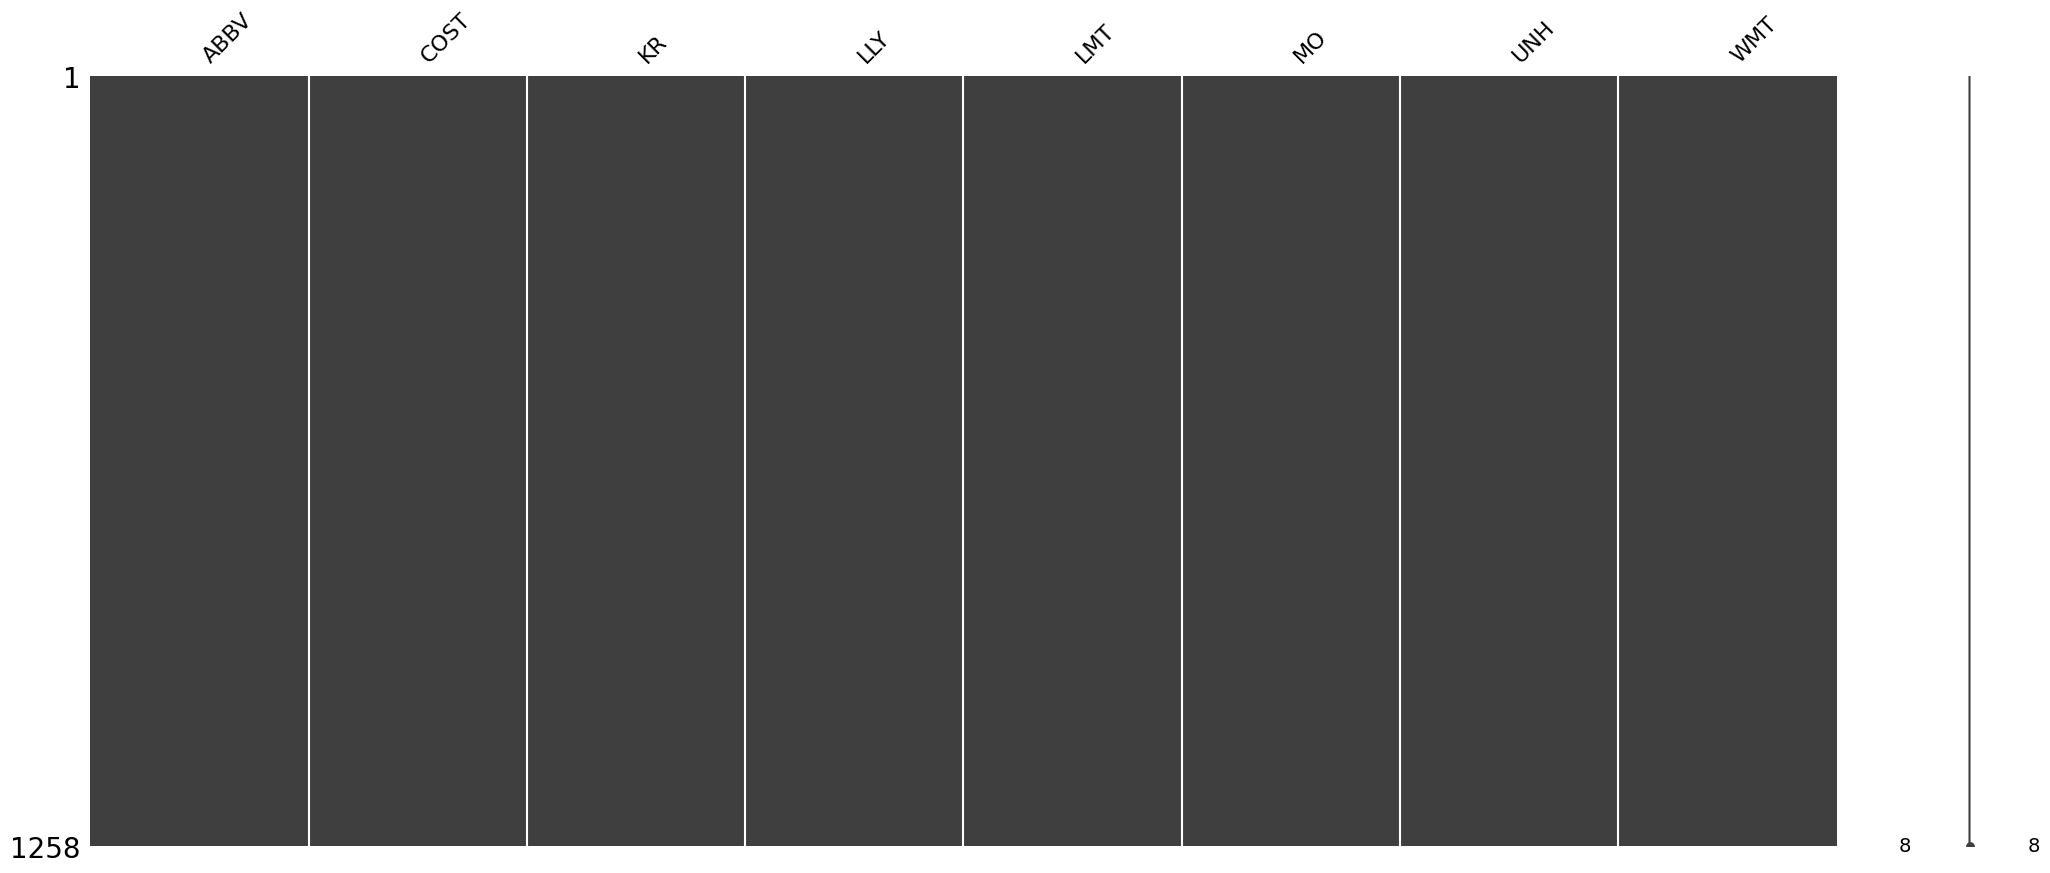

In [62]:
msno.matrix(precios)

In [63]:
precios_weekly = precios.resample("W-WED").first()
precios_weekly

Ticker,ABBV,COST,KR,LLY,LMT,MO,UNH,WMT
Date,,,,,,,,
2019-01-02,66.900146,186.144623,23.834394,105.114410,224.121170,30.135334,221.528564,28.215210
2019-01-09,64.695892,182.199219,23.878046,101.847885,218.491196,29.970325,215.487427,28.070116
2019-01-16,66.127922,191.490097,24.864603,106.084290,234.932266,29.860306,222.784103,28.704916
2019-01-23,66.180031,192.235565,25.257471,109.030609,236.032776,28.760260,236.340210,29.242977
2019-01-30,65.178230,191.190063,25.065397,105.215042,241.493423,26.480705,242.126572,29.732677
...,...,...,...,...,...,...,...,...
2023-12-06,134.839066,575.559570,43.045002,586.197205,433.149231,37.151459,540.285645,50.952312
2023-12-13,140.123169,593.241699,43.560341,583.449951,432.510742,36.515182,537.521057,50.080551
2023-12-20,146.666718,612.497009,42.383820,568.969543,430.730865,37.213322,523.765991,49.985287


In [64]:
retornos = np.log(precios_weekly).diff().dropna()
cov_matrix = retornos.cov()

In [65]:
retornos_medios = retornos.mean().to_numpy()
cov_matrix = retornos.cov().to_numpy()

In [66]:
num_act = len(precios.columns)
num_act

8

Hemos decidido optimizar la cartera, maximizando la rentabilidad y que todos los activos estén incluidos en nuestro fondo, al menos en un 5%, para evitar que la alocación se concentre solamente en el activo de máxima rentabilidad.


In [67]:
pesos = cp.Variable(num_act)
riesgo = cp.quad_form(pesos, cov_matrix)

In [68]:
rentabilidad = pesos @ retornos_medios

In [69]:
constraints = [cp.sum(pesos) == 1,
               pesos >= 0.05
               ]

In [70]:
objetivo = cp.Maximize(rentabilidad)
problema = cp.Problem(objetivo, constraints)
resultado = problema.solve()
pesos_optimos = pesos.value

In [71]:
pesos_optimos

array([0.05000001, 0.05      , 0.05      , 0.64999997, 0.05000001,
       0.05      , 0.05000001, 0.05      ])

In [72]:
rentabilidad_semanal_cartera = retornos @ pesos_optimos
rentabilidad_semanal_cartera

,0
Date,
2019-01-09,-0.026362
2019-01-16,0.038322
2019-01-23,0.021063
2019-01-30,-0.025517
2019-02-06,0.030680
...,...
2023-12-06,-0.008447
2023-12-13,-0.001080
2023-12-20,-0.014476


In [73]:
rentabilidad_cartera = (pesos_optimos @ retornos_medios)* (52)
std_cartera = np.sqrt(riesgo.value*52)
cartera_1 = (rentabilidad_cartera, std_cartera)
print(cartera_1)

(np.float64(0.26974497437505135), np.float64(0.2202550566507522))


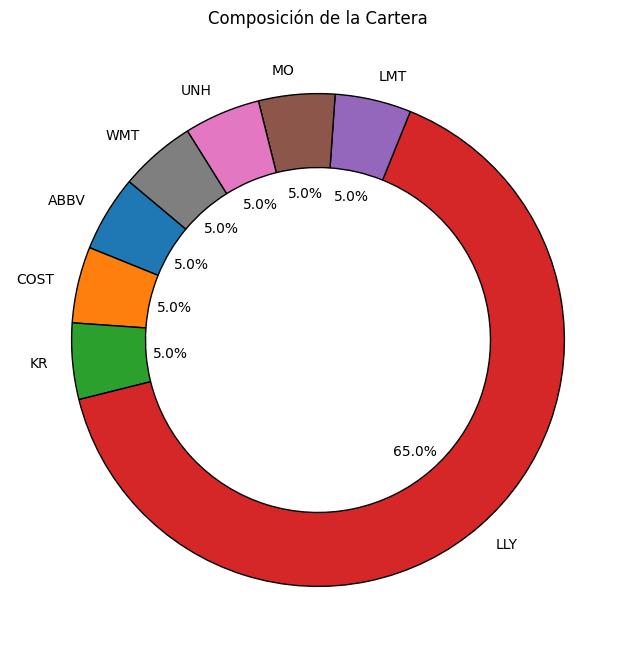

In [74]:
plt.figure(figsize=(8, 8))

plt.pie(pesos_optimos, labels = precios.columns, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3, 'edgecolor': 'black'})

# Añadir título
plt.title('Composición de la Cartera')

# Mostrar el gráfico
plt.show()

# **ESTIMACIÓN DE INDICADORES**

BETA DE LA CARTERA FRENTE AL ÍNDICE SP500

In [75]:
precios_sp500 = yf.download("^GSPC", start="2019-01-01", end="2023-12-31", multi_level_index = False, auto_adjust = False)["Adj Close"]
precios_weekly_sp500 = precios_sp500.resample("W-WED").first()
retornos_sp500 = np.log(precios_weekly_sp500).diff().dropna()

[*********************100%***********************]  1 of 1 completed


In [76]:
datos_beta = pd.concat([retornos_sp500, rentabilidad_semanal_cartera], join = 'inner', axis = 1)
datos_beta.columns = ['Retornos SP500', 'Ret semanal cartera']
datos_beta.head()

,Retornos SP500,Ret semanal cartera
Date,,
2019-01-09,-0.025068,-0.026362
2019-01-16,0.058992,0.038322
2019-01-23,0.015029,0.021063
2019-01-30,0.002414,-0.025517
2019-02-06,0.023108,0.030680


In [77]:
X = datos_beta['Retornos SP500']
y = datos_beta['Ret semanal cartera']
X_sm = sm.add_constant(X)
modelo = sm.OLS(y, X_sm).fit()
print(modelo.summary())

                             OLS Regression Results                            
Dep. Variable:     Ret semanal cartera   R-squared:                       0.194
Model:                             OLS   Adj. R-squared:                  0.190
Method:                  Least Squares   F-statistic:                     62.14
Date:                 Wed, 23 Apr 2025   Prob (F-statistic):           8.91e-14
Time:                         19:18:36   Log-Likelihood:                 568.75
No. Observations:                  261   AIC:                            -1133.
Df Residuals:                      259   BIC:                            -1126.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0040      0.0

Podemos ver que los retornos del SP500 explican en un 19.4 % los retornos de nuestro fondo, no elevado. No obstante, podemos percibir un plus de rentabilidad generado por nuestro fondo del 0.4% y una beta del 0.49. Es decir, cuando el fondo suba un 1%, nosotros nos moveremos un 0,5%, la mitad.

ANÁLISIS DE EXPOSICIÓN FRENTE A FACTORES FAMA Y FRENCH. Usaremos datos diarios para poder convertirlos a semanales y así eliminar el ruido al e

In [78]:
dateparse = lambda x: pd.to_datetime(x, format="%Y%m%d")
factores = pd.read_csv("/content/F-F_Research_Data_Factors_daily.CSV", skiprows = 4, nrows = 25907-6 ,index_col=0, parse_dates=True, date_parser = dateparse)

<ipython-input-78-b75fa9956a51>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factores = pd.read_csv("/content/F-F_Research_Data_Factors_daily.CSV", skiprows = 4, nrows = 25907-6 ,index_col=0, parse_dates=True, date_parser = dateparse)


In [79]:
factores = factores/100
factores

,Mkt-RF,SMB,HML,RF
1926-07-01,0.0010,-0.0025,-0.0027,0.00009
1926-07-02,0.0045,-0.0033,-0.0006,0.00009
1926-07-06,0.0017,0.0030,-0.0039,0.00009
1926-07-07,0.0009,-0.0058,0.0002,0.00009
1926-07-08,0.0021,-0.0038,0.0019,0.00009
...,...,...,...,...
2024-12-24,0.0111,-0.0009,-0.0005,0.00017
2024-12-26,0.0002,0.0104,-0.0019,0.00017
2024-12-27,-0.0117,-0.0066,0.0056,0.00017
2024-12-30,-0.0109,0.0012,0.0074,0.00017


In [80]:
price_factores = np.exp(factores.cumsum())
price_factores_weekly = price_factores.resample("W-WED").first()
retornos_factores = np.log(price_factores_weekly).diff().dropna()

In [81]:
price_factores_weekly.tail(20)

,Mkt-RF,SMB,HML,RF
2024-08-21,2627.268520,2.764888,43.094699,23.380445
2024-08-28,2638.590099,2.767931,43.341040,23.406178
2024-09-04,2649.430526,2.795190,44.420452,23.431939
2024-09-11,2601.907217,2.755503,44.504931,23.451161
2024-09-18,2641.758307,2.746699,42.969906,23.474624
2024-09-25,2708.093065,2.821588,43.658588,23.498110
2024-10-02,2716.501179,2.768484,42.978500,23.521620
2024-10-09,2691.893155,2.729996,43.280405,23.543034
2024-10-16,2730.663776,2.706889,43.168022,23.563055
2024-10-23,2764.458351,2.779580,43.868653,23.583092


In [82]:
rentabilidad_semanal_cartera = datos_beta['Ret semanal cartera']
datos_ff = pd.concat([retornos_factores, rentabilidad_semanal_cartera], join = 'inner', axis = 1)
datos_ff.head()

,Mkt-RF,SMB,HML,RF,Ret semanal cartera
2019-01-09,-0.0135,0.0164,0.0212,0.00042,-0.026362
2019-01-16,0.0648,0.0243,-0.0244,0.00050,0.038322
2019-01-23,0.0148,-0.0033,0.0095,0.00050,0.021063
2019-01-30,0.0014,-0.0071,0.0030,0.00040,-0.025517
2019-02-06,0.0234,0.0026,-0.0157,0.00050,0.030680


In [83]:
X = datos_ff[["Mkt-RF", "SMB", "HML"]]
Y = datos_ff.loc[:, "Ret semanal cartera"] - datos_ff["RF"]

X_sm = sm.add_constant(X)

modelo = sm.OLS(Y, X_sm).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     23.22
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           2.48e-13
Time:                        19:18:36   Log-Likelihood:                 571.93
No. Observations:                 261   AIC:                            -1136.
Df Residuals:                     257   BIC:                            -1122.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.952      0.0

Podemos ver que los factores explican un 20,4% los retornos del fondo. Podemos ver que nuestra cartera tiene una beta del 0.53 frente al mercado y con un SMB de -0.31, tiende a comportarse como entidad de gran capitalización.

ANÁLISIS DE FACTORES SECTORIALES. En el factor de health, tenemos datos faltantes de 1923 hasta 1969, por lo que eliminaremos los datos anteriores.

In [84]:
factores_sec = pd.read_csv("/content/49_Industry_Portfolios_Daily.csv", skiprows = 9 ,
                      nrows = 25911-10, parse_dates = True, index_col = 0, date_parser = dateparse)

<ipython-input-84-bde883f4f209>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factores_sec = pd.read_csv("/content/49_Industry_Portfolios_Daily.csv", skiprows = 9 ,


In [85]:
factores_sec.tail()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
2024-12-24,1.00,0.58,0.84,0.64,-0.54,0.49,1.70,0.88,0.52,0.20,...,0.68,0.96,0.70,1.57,1.24,1.24,0.57,0.76,1.55,0.96
2024-12-26,-0.11,-0.02,-0.23,-0.33,0.18,1.69,-0.47,0.07,0.40,0.34,...,-0.01,0.13,-0.12,-0.25,0.25,0.32,0.51,0.08,0.28,0.25
2024-12-27,-0.41,0.22,-0.27,-0.06,-0.29,-1.46,-1.37,-1.09,-0.56,-0.73,...,-0.61,-0.63,-0.84,-1.25,-0.68,-0.90,-0.66,-1.10,-1.14,-0.65
2024-12-30,-0.93,-1.05,-0.57,-1.00,-0.99,-1.56,-0.76,-1.25,-1.25,-1.26,...,-1.11,-0.80,-1.00,-1.21,-1.27,-0.81,-0.60,-0.45,-1.13,-1.01
2024-12-31,0.70,0.75,0.40,0.36,0.32,0.15,-0.63,0.05,0.30,0.27,...,0.41,-0.15,0.08,-0.55,0.11,0.03,0.06,0.58,-0.24,0.05


In [86]:
factores_sec = factores_sec[['Rtail', 'Hlth ', 'Drugs', 'Aero ', 'Smoke']]


In [87]:
factores_sec.replace(-99.99, np.nan, inplace=True)

<Axes: >

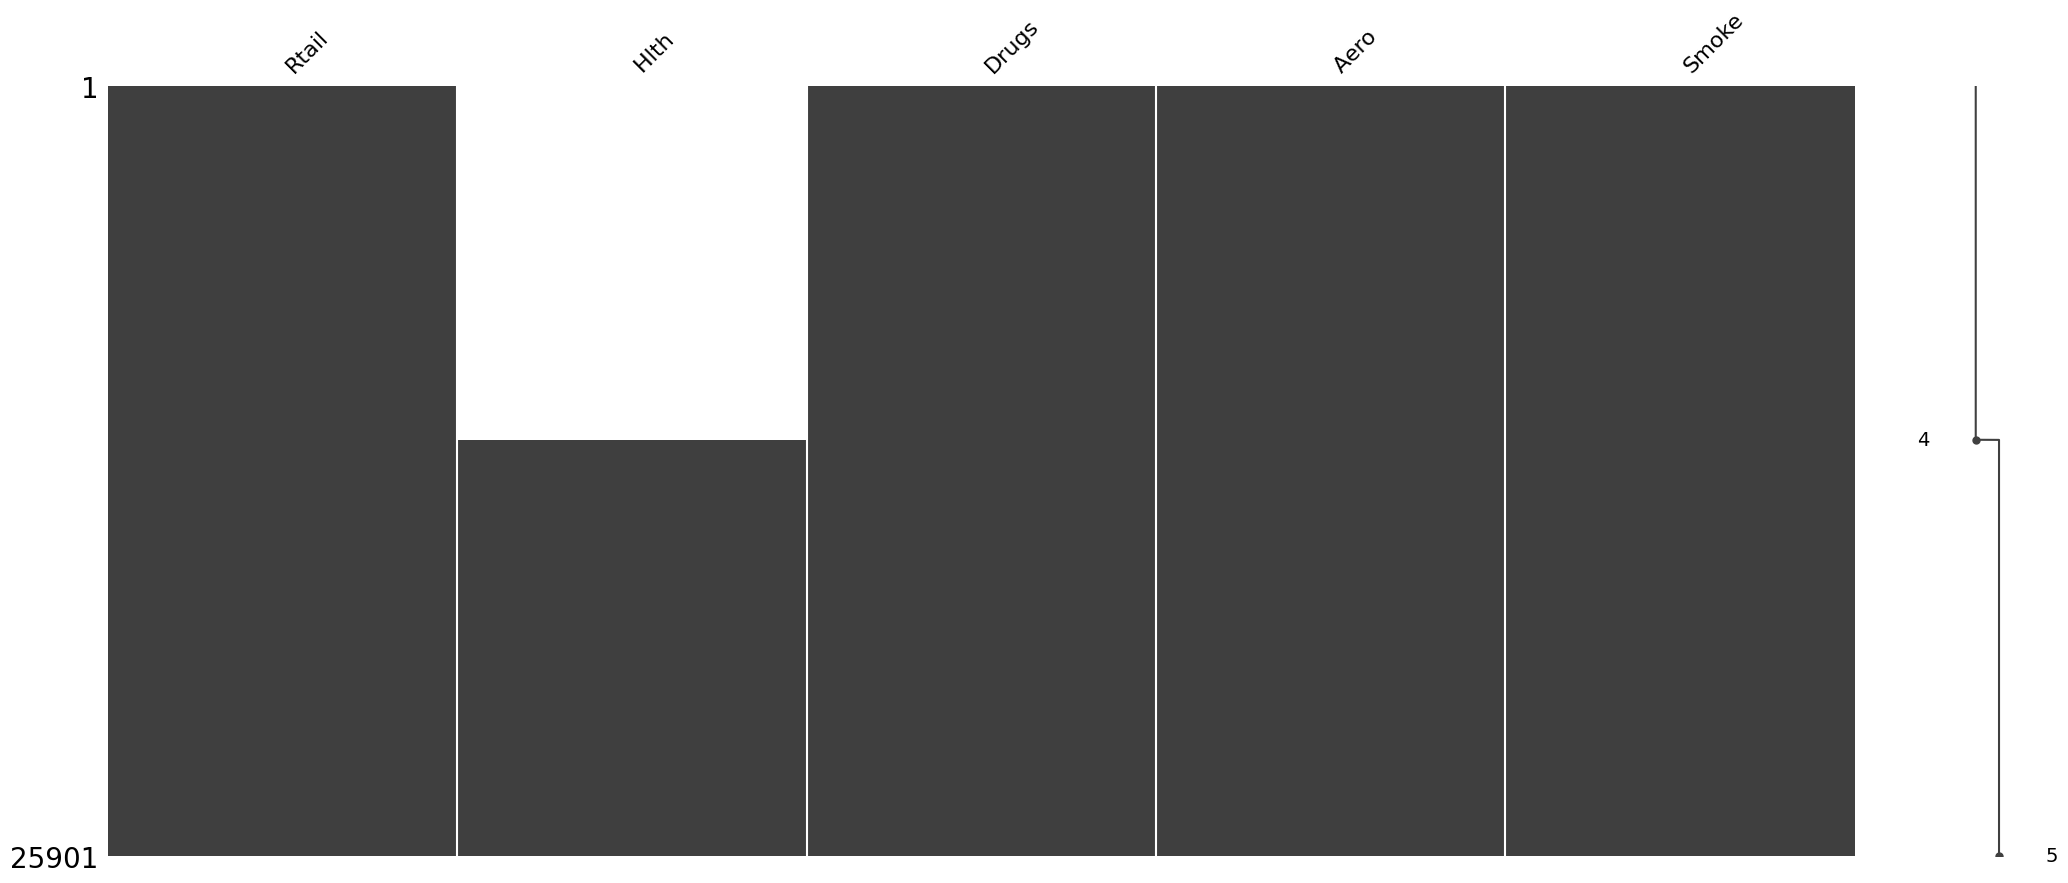

In [88]:
msno.matrix(factores_sec)

<Axes: >

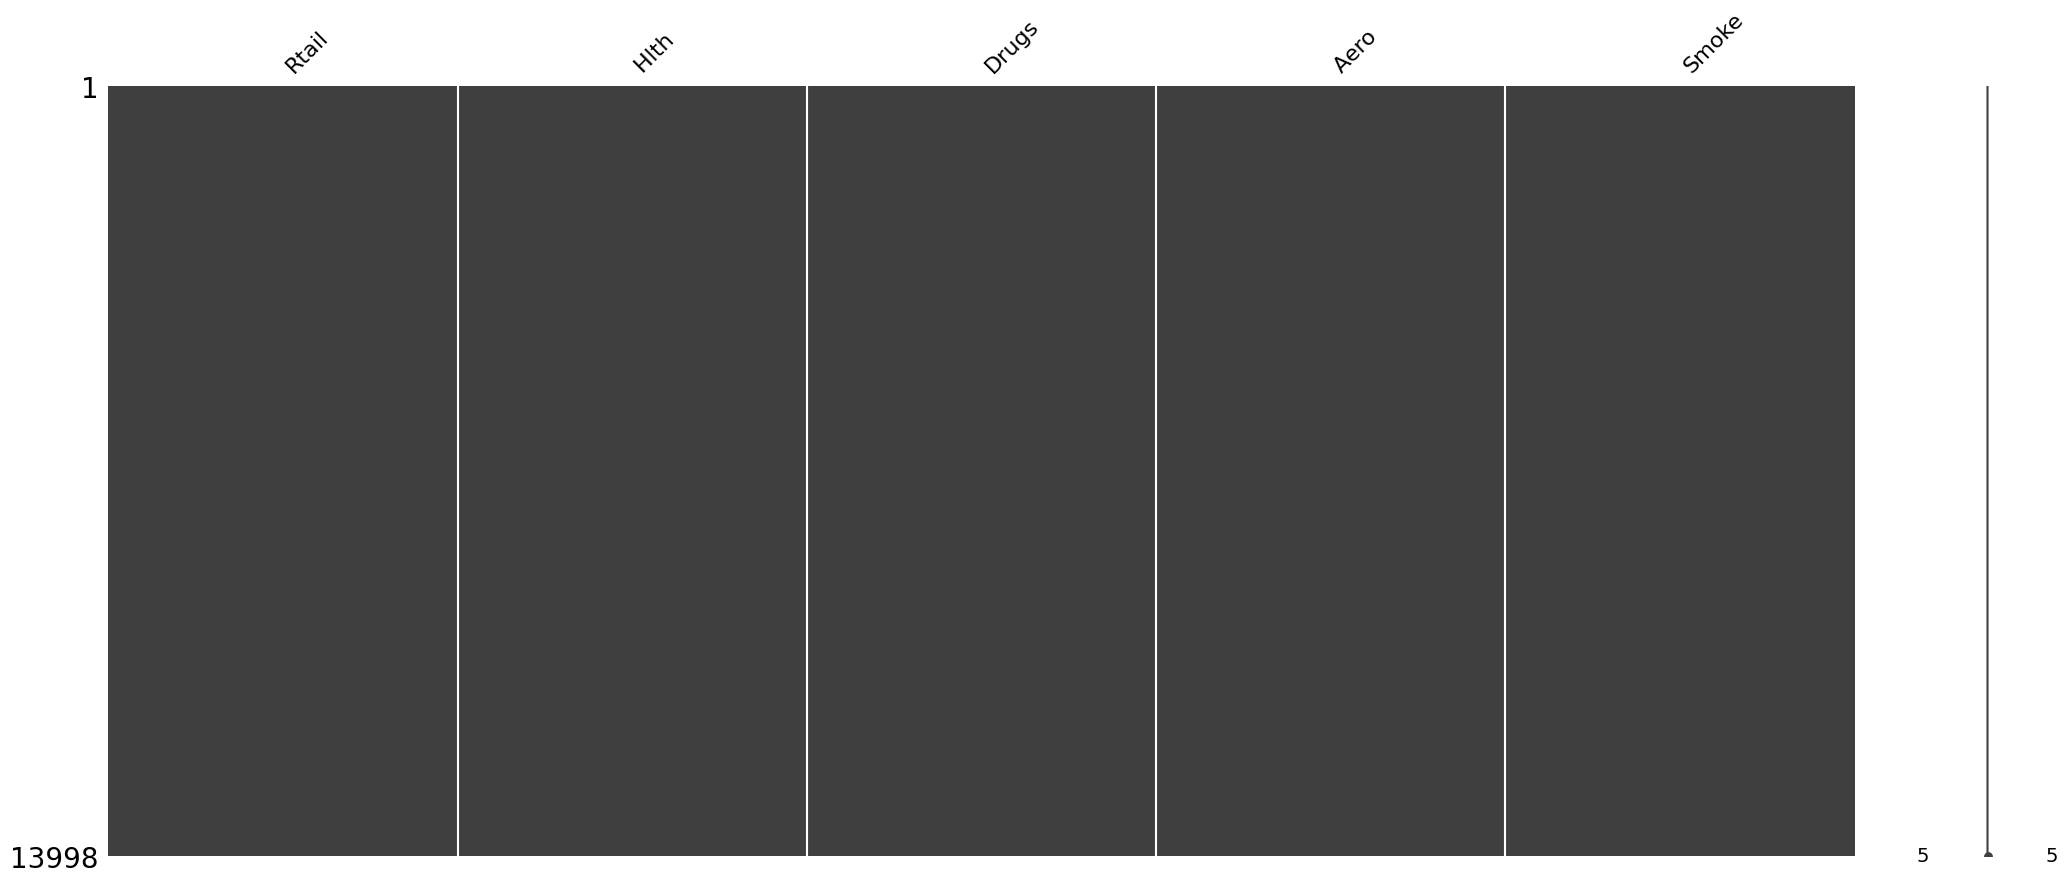

In [89]:
factores_sec = factores_sec.dropna(axis = 0, how = 'any')
msno.matrix(factores_sec)

In [90]:
factores_sec = factores_sec / 100
price_factores_sec = np.exp(factores_sec.cumsum())

In [91]:
price_factores_sec

,Rtail,Hlth,Drugs,Aero,Smoke
1969-07-01,1.004410,0.991040,1.006622,0.999200,1.008435
1969-07-02,1.005214,1.023471,1.013490,1.004108,1.018061
1969-07-03,1.006521,1.006924,1.021937,1.005515,1.017858
1969-07-07,1.001301,0.972583,1.019487,0.988072,1.015215
1969-07-08,0.988566,1.001701,1.006722,0.971319,1.001501
...,...,...,...,...,...
2024-12-24,1628.639040,324.666986,1290.777463,1960.784643,10638.130047
2024-12-26,1624.572527,325.414580,1292.585817,1968.052984,10657.295925
2024-12-27,1604.391763,323.888720,1281.773571,1960.000486,10626.434538
2024-12-30,1585.095600,319.961284,1264.206586,1936.233752,10521.751870


In [92]:
price_factores_sec_weekly = price_factores_sec.resample("W-WED").first()
retornos_factores_sec = np.log(price_factores_sec_weekly).diff().dropna()

In [93]:
price_factores_sec_weekly

,Rtail,Hlth,Drugs,Aero,Smoke
1969-07-02,1.004410,0.991040,1.006622,0.999200,1.008435
1969-07-09,1.006521,1.006924,1.021937,1.005515,1.017858
1969-07-16,0.966475,1.048122,0.992627,0.941011,0.989654
1969-07-23,0.959062,1.050325,1.002303,0.922009,0.990248
1969-07-30,0.933513,1.000100,0.976676,0.897897,1.001401
...,...,...,...,...,...
2024-12-04,1578.925766,365.804852,1335.552042,1981.679507,11493.075471
2024-12-11,1627.662149,355.348856,1329.422611,1962.942692,11409.481509
2024-12-18,1651.270053,338.966065,1294.137851,1928.118624,10970.882536
2024-12-25,1599.905750,318.683995,1254.509577,1924.651132,10560.754462


In [94]:
datos_sec = pd.concat([retornos_factores_sec, rentabilidad_semanal_cartera], join = 'inner', axis = 1)
datos_sec.head()

,Rtail,Hlth,Drugs,Aero,Smoke,Ret semanal cartera
2019-01-09,0.0122,-0.0143,-0.0075,-0.0167,0.0014,-0.026362
2019-01-16,0.0660,0.0817,0.0540,0.0975,0.0132,0.038322
2019-01-23,0.0083,0.0356,0.0090,0.0186,0.0173,0.021063
2019-01-30,-0.0035,-0.0057,-0.0184,0.0087,-0.0416,-0.025517
2019-02-06,0.0217,0.0268,0.0223,0.0530,0.0968,0.030680


In [95]:
X = datos_sec[['Rtail', 'Hlth ', 'Drugs', 'Aero ', 'Smoke']]
Y = datos_sec.loc[:, "Ret semanal cartera"]

X_sm = sm.add_constant(X)

modelo = sm.OLS(Y, X_sm).fit()

print(modelo.summary())

                             OLS Regression Results                            
Dep. Variable:     Ret semanal cartera   R-squared:                       0.649
Model:                             OLS   Adj. R-squared:                  0.642
Method:                  Least Squares   F-statistic:                     94.23
Date:                 Wed, 23 Apr 2025   Prob (F-statistic):           6.55e-56
Time:                         19:18:38   Log-Likelihood:                 677.24
No. Observations:                  261   AIC:                            -1342.
Df Residuals:                      255   BIC:                            -1321.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.24

Según los factores elegidos, éstos explicarían un 64,2% los retornos de nuestro fondo, una explicabilidad considerable. Podemos ver que nuestro fondo genera un plus de rentabilidad del 0,26%.
Además, nuestra cartera tiene una beta negativa frente al sector sanitario: -0.25 y una beta del 1.26 frente al sector de la medicina, los dos altamente significativos.

Vamos a tratar de explicar más profundamente esta beta negativa, algo extraña por nuestra fuerte exposición al sector sanitario.

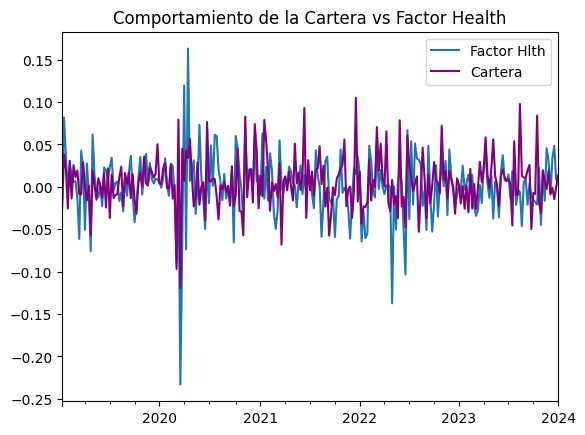

In [96]:
datos_sec['Hlth '].plot(label='Factor Hlth')
datos_sec['Ret semanal cartera'].plot(color='purple', label='Cartera')
plt.title('Comportamiento de la Cartera vs Factor Health')
plt.legend()
plt.show()

A priori, vemos que el factor sanitario es un poco más volátil que la cartera en ciertos periodos, sobre todo en la época del COVID y de la subida de tipo de interés por parte de la FED, con bajadas muy pronunciadas. Pero si miramos más de cerca podemos ver casos que pueden explicar esta divergencia, entre ellos, en Mayo del 2022 con la subida de tipos de la FED, donde el factor disminuyó drásticamente mientras que LLY (principal componente de nuestra cartera) resistió bastante bien, principalmente gracias a la salida de un nuevo medicamento esencial para pacientes diabéticos aún no comercializado (Mounjaro), superando a otros tratamientos existentes, y por ende, el mercado tuvo enormes expectativas frente a éste.

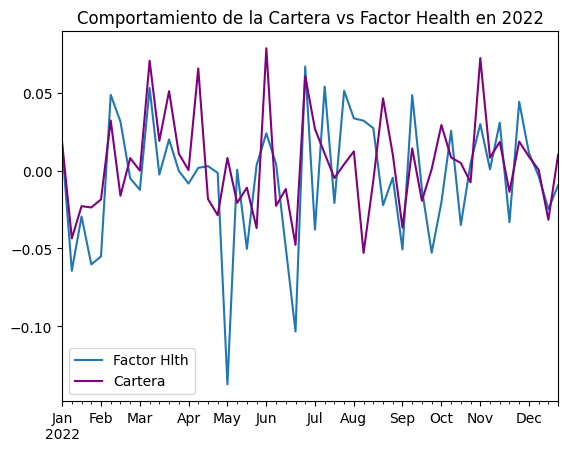

In [97]:
datos_sec['Hlth '].loc['2022'].plot(label='Factor Hlth')
datos_sec['Ret semanal cartera'].loc['2022'].plot(color='purple', label='Cartera')
plt.title('Comportamiento de la Cartera vs Factor Health en 2022')
plt.legend()
plt.show()

O como fue el caso en Agosto de 2023, donde se publicaron incrementos del 28% en las ventas de LLY para los 3 meses acabados en junio de 2023 frente al año pasado, resultados importantes muy visibles en el comportamiento de nuestra cartera frente al factor sanitario. El factor bajó principalmente por el éxito de estos medicamentos ,conocidos del tipo GLD-1 (Mounjaro de LLY incluido), muy populares para combatir la obesidad y la diabetes: Supuso una rápida caída de los precios de las acciones de competidores que no comercializaban esta variante y de empresas proveedoras del sector salud.

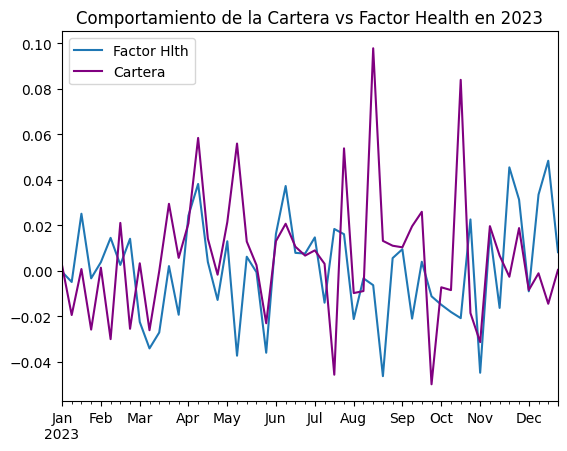

In [98]:
datos_sec['Hlth '].loc['2023'].plot(label='Factor Hlth')
datos_sec['Ret semanal cartera'].loc['2023'].plot(color='purple', label='Cartera')
plt.title('Comportamiento de la Cartera vs Factor Health en 2023')
plt.legend()
plt.show()

# **BACKTESTING**

Para el periodo bull market, elegiremos las fechas que van desde septiembre de 2020 hasta el de 2021.

<Axes: xlabel='Date'>

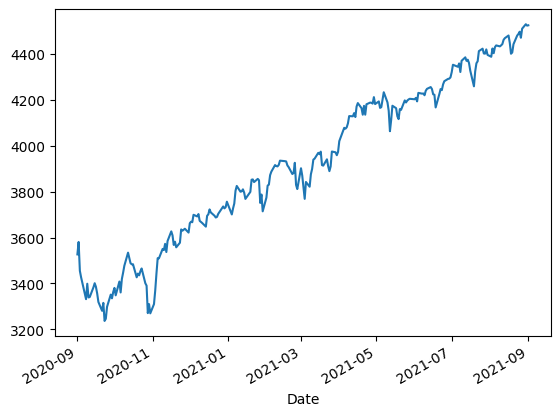

In [99]:
precios_sp500.loc['2020-09-01': '2021-09-01'].plot()

In [100]:
datos_beta_bull = datos_beta.loc['2020-09-01': '2021-09-01']


In [101]:
X = datos_beta_bull['Retornos SP500']
y = datos_beta_bull['Ret semanal cartera']
X_sm = sm.add_constant(X)
modelo = sm.OLS(y, X_sm).fit()
print(modelo.summary())

                             OLS Regression Results                            
Dep. Variable:     Ret semanal cartera   R-squared:                       0.115
Model:                             OLS   Adj. R-squared:                  0.098
Method:                  Least Squares   F-statistic:                     6.650
Date:                 Wed, 23 Apr 2025   Prob (F-statistic):             0.0128
Time:                         19:18:39   Log-Likelihood:                 109.23
No. Observations:                   53   AIC:                            -214.5
Df Residuals:                       51   BIC:                            -210.5
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0051      0.0

Podemos ver que los retornos del SP500 explican en un 11,5% los retornos del fondo donde podemos ver que tenemos una beta del 0.6 frente al sp500.

In [102]:
datos_ff_bull = datos_ff.loc['2020-09-01': '2021-09-01']

In [103]:
X = datos_ff_bull[["Mkt-RF", "SMB", "HML"]]
Y = datos_ff_bull.loc[:, "Ret semanal cartera"] - datos_ff_bull["RF"]

X_sm = sm.add_constant(X)

modelo = sm.OLS(Y, X_sm).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     2.363
Date:                Wed, 23 Apr 2025   Prob (F-statistic):             0.0826
Time:                        19:18:39   Log-Likelihood:                 109.56
No. Observations:                  53   AIC:                            -211.1
Df Residuals:                      49   BIC:                            -203.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.005      1.189      0.2

Podemos ver una explicabilidad del 7,3% pero ningun factor es estadísticamente significativo.

In [104]:
datos_sec_bull = datos_sec.loc['2020-09-01': '2021-09-01']
datos_sec_bull.head()

,Rtail,Hlth,Drugs,Aero,Smoke,Ret semanal cartera
2020-09-02,0.0269,-0.0136,-0.0035,0.0165,0.0159,-0.006401
2020-09-09,-0.0061,-0.0025,-0.0205,-0.0087,-0.0091,0.001321
2020-09-16,-0.0405,-0.0111,-0.0219,-0.0427,0.0091,-0.022252
2020-09-23,-0.0201,0.0193,0.0402,0.0500,-0.0219,0.024217
2020-09-30,-0.0073,-0.0656,-0.0307,-0.0991,-0.0388,-0.022806


In [105]:
X = datos_sec_bull[['Rtail', 'Hlth ', 'Drugs', 'Aero ', 'Smoke']]
Y = datos_sec_bull.loc[:, "Ret semanal cartera"]

X_sm = sm.add_constant(X)

modelo = sm.OLS(Y, X_sm).fit()

print(modelo.summary())

                             OLS Regression Results                            
Dep. Variable:     Ret semanal cartera   R-squared:                       0.499
Model:                             OLS   Adj. R-squared:                  0.446
Method:                  Least Squares   F-statistic:                     9.370
Date:                 Wed, 23 Apr 2025   Prob (F-statistic):           3.04e-06
Time:                         19:18:40   Log-Likelihood:                 124.30
No. Observations:                   53   AIC:                            -236.6
Df Residuals:                       47   BIC:                            -224.8
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.004      1.16

Podemos ver que aqui los retornos de los factores explican un 44,6% donde nuestra cartera tiene una beta frente al sector farmacéutico del 1.32: cuando el sector suba un 1%, nos moveremos un 1,32%.

Para el periodo bear market, elegiremos las fechas que van desde diciembre de 2021 hasta el de 2022

<Axes: xlabel='Date'>

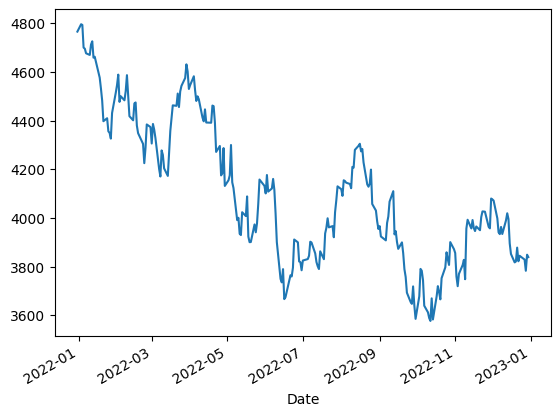

In [106]:
precios_sp500.loc['2021-12-31': '2022-12-31'].plot()

In [107]:
datos_beta_bear = pd.concat([retornos_sp500.loc['2021-12-31': '2022-12-31'], rentabilidad_semanal_cartera.loc['2021-12-31': '2022-12-31']], join = 'inner', axis = 1)
datos_beta_bear.columns = ['Retornos SP500', 'Ret semanal cartera']
datos_beta_bear.head()

,Retornos SP500,Ret semanal cartera
Date,,
2022-01-05,0.011140,0.017988
2022-01-12,-0.017453,-0.043607
2022-01-19,-0.007914,-0.022902
2022-01-26,-0.038575,-0.023725
2022-02-02,-0.035471,-0.018581


In [108]:

X = datos_beta_bear['Retornos SP500']
y = datos_beta_bear['Ret semanal cartera']
X_sm = sm.add_constant(X)
modelo_bear = sm.OLS(y, X_sm).fit()
print(modelo_bear.summary())

                             OLS Regression Results                            
Dep. Variable:     Ret semanal cartera   R-squared:                       0.264
Model:                             OLS   Adj. R-squared:                  0.249
Method:                  Least Squares   F-statistic:                     17.93
Date:                 Wed, 23 Apr 2025   Prob (F-statistic):           9.82e-05
Time:                         19:18:40   Log-Likelihood:                 115.53
No. Observations:                   52   AIC:                            -227.1
Df Residuals:                       50   BIC:                            -223.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0066      0.0

Como el p-valor es menor que 0.05 para la variable Retornos SP500, podemos afirmar que su beta es relevante. Por lo tanto, si el mercado sube un 1%, subiremos un 0.51%

In [109]:
datos_ff_bear = datos_ff.loc['2021-12-31': '2022-12-31']
X = datos_ff_bear[["Mkt-RF", "SMB", "HML", "RF"]]
Y = datos_ff_bear.loc[:, "Ret semanal cartera"] - datos_ff_bear["RF"]
X_sm = sm.add_constant(X)
modelo_bear_ff = sm.OLS(Y, X_sm).fit()
print(modelo_bear_ff.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     4.175
Date:                Wed, 23 Apr 2025   Prob (F-statistic):            0.00565
Time:                        19:18:40   Log-Likelihood:                 115.46
No. Observations:                  52   AIC:                            -220.9
Df Residuals:                      47   BIC:                            -211.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0073      0.005      1.349      0.1

Como el p-valor es mayor que 0.05 para todos los factores menos para Mkt-RF, podemos afirmar que solo el beta de este factor es relevante. Al tener un valor mayor que 0, observamos que nuestra cartera se movería menos agresivamente que el mercado.

In [110]:
datos_sec_bear = pd.concat([retornos_factores_sec.loc['2021-12-31': '2022-12-31'], rentabilidad_semanal_cartera.loc['2021-12-31': '2022-12-31']], join = 'inner', axis = 1)
X = datos_sec_bear[['Rtail', 'Hlth ', 'Drugs', 'Aero ', 'Smoke']]
Y = datos_sec_bear.loc[:, "Ret semanal cartera"]
X_sm = sm.add_constant(X)
modelo_bear_sec = sm.OLS(Y, X_sm).fit()
print(modelo_bear_sec.summary())

                             OLS Regression Results                            
Dep. Variable:     Ret semanal cartera   R-squared:                       0.677
Model:                             OLS   Adj. R-squared:                  0.642
Method:                  Least Squares   F-statistic:                     19.30
Date:                 Wed, 23 Apr 2025   Prob (F-statistic):           2.63e-10
Time:                         19:18:40   Log-Likelihood:                 136.96
No. Observations:                   52   AIC:                            -261.9
Df Residuals:                       46   BIC:                            -250.2
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.003      0.77

Como el p-valor es mayor que 0.05 para todos los factores menos para drugs, solo podemos afirmar que el factor Drugs es relevante. Esto nos indica que según la regresión, nuestra cartera se comporta de manera muy parecida al sector farmacéutico teniendo una beta cercana a uno (1.13).


In [111]:

rend_real_bull = rentabilidad_semanal_cartera['2020-09-01':'2021-09-01'].mean() * 52
rend_real_bear = rentabilidad_semanal_cartera['2021-12-31':'2022-12-31'].mean() * 52
std_real_bull = rentabilidad_semanal_cartera['2020-09-01':'2021-09-01'].std() * np.sqrt(52)
std_real_bear = rentabilidad_semanal_cartera['2021-12-31':'2022-12-31'].std() * np.sqrt(52)
print(rend_real_bull, rend_real_bear)
print(std_real_bull, std_real_bear)

0.429083141511228 0.23087091605055876
0.23850122793819165 0.2226681333444593


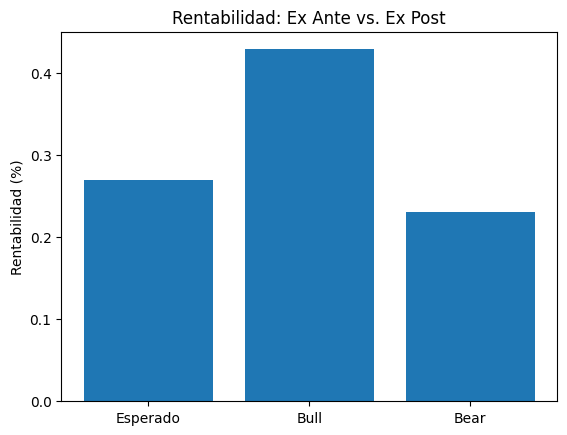

In [112]:

nombres = ['Esperado', 'Bull', 'Bear']
valores = [rentabilidad_cartera, rend_real_bull, rend_real_bear]
plt.bar(nombres, valores)
plt.title('Rentabilidad: Ex Ante vs. Ex Post')
plt.ylabel('Rentabilidad (%)')
plt.show()


Podemos ver que la esperanza de rentabilidad de nuestro fondo se acerca más al rendimiento real en periodos de bear market, y donde podemos ver que sus resultados en el caso de bull market se han disparado, logrando una rentabilidad del 42%, casi el doble.

# **VaR Montecarlo**

Utilizamos la propuesta de Black-Scholes Merton para los próximos 30 días, y calculamos 100000 números aleatorios que se comportan como una N(0,1) para realizar las simulaciones.

Hemos considerado que el precio inicial debería ser su precio actual a día de hoy, 21 de Abril, calculados con los pesos optimizados por sus precios actuales y los retornos y la volatilidad calculados en la optimización.

In [113]:
precios_var = yf.download(tickers, start = "2025-04-21", end = "2025-04-22", auto_adjust = True)['Close']
precios_var

[*********************100%***********************]  8 of 8 completed


Ticker,ABBV,COST,KR,LLY,LMT,MO,UNH,WMT
Date,,,,,,,,
2025-04-21,170.160004,957.77002,72.309998,818.02002,458.329987,57.630001,425.329987,92.410004


In [114]:

precio_inicial = (pesos_optimos @ precios_var.T).to_numpy()
retorno_medio = rentabilidad_cartera
volatilidad = std_cartera
dias = 30
num_simulaciones = 100000

tiempo = dias / 365


simulaciones = precio_inicial * np.exp((retorno_medio - 0.5 * volatilidad ** 2) * tiempo
                                       + volatilidad * np.sqrt(tiempo) * np.random.standard_normal(num_simulaciones))

rentabilidades_ordenadas = np.sort(simulaciones - precio_inicial)


In [115]:
var_95 = np.percentile(rentabilidades_ordenadas, 5)
var_95

np.float64(-52.09906372823357)

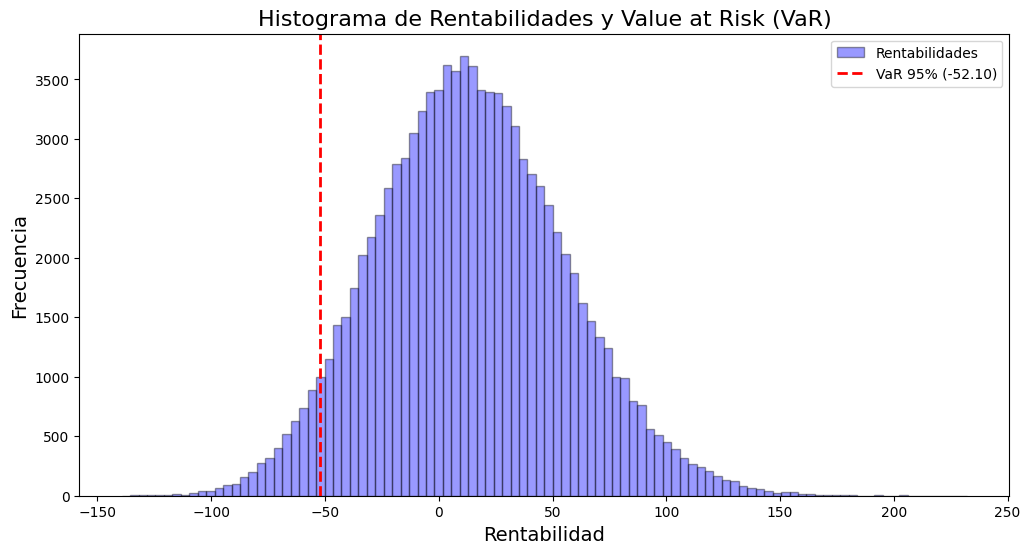

In [116]:
plt.figure(figsize=(12, 6))
plt.hist(rentabilidades_ordenadas, bins=100, color='blue', alpha=0.4, edgecolor='black', label='Rentabilidades')


plt.axvline(var_95, color='red', linestyle='dashed', linewidth=2, label=f'VaR 95% ({var_95:.2f})')


plt.title('Histograma de Rentabilidades y Value at Risk (VaR)', fontsize=16)
plt.xlabel('Rentabilidad', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)


plt.legend()


plt.show()